# PART 11: Load Cleaned Data & Prepare Model Inputs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
# Path Settings
ROOT = Path("..")
DATA_PROCESSED = ROOT / "data" / "processed" / "delivery_cleaned.csv"
MODELS_DIR = ROOT / "models"
OUT_DIR = ROOT / "data" / "processed"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Upload cleaned data
df = pd.read_csv(DATA_PROCESSED)
print("Cleaned data shape:", df.shape)

Cleaned data shape: (43515, 22)


In [4]:
# Target and Features
target = 'Delivery_Time'

# Generated in notebook 01: Order_Hour, Order_Week, Order_Month, Weekday, Order_Period etc.
numerical_features   = ['Agent_Age', 'Agent_Rating', 'Distance_km', 'Order_Hour', 'Order_Week', 'Order_Month']
categorical_features = ['Traffic', 'Weather', 'Vehicle', 'Area', 'Category', 'Order_Period', 'Weekday']

# Create X, Y
X = df[numerical_features + categorical_features].copy()
y = df[target].copy()

# One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print("Final feature matrix shape:", X.shape)

Final feature matrix shape: (43515, 45)


In [5]:
df["_row_id"] = df.index  # original row ID

# TIME-BASED SPLIT (%20 test)

# 1) Create a timestamp from Order_Date and Order_Time (if applicable).
if "Order_Time" in df.columns:
    df["_timestamp"] = pd.to_datetime(
        df["Order_Date"].astype(str) + " " + df["Order_Time"].astype(str),
        errors="coerce"
    )
else:
    df["_timestamp"] = pd.to_datetime(df["Order_Date"], errors="coerce")

# 2) Sort by timestamp
df_sorted = df.sort_values("_timestamp").reset_index(drop=True)

# 3) Cut-off point: last 20% of the test
cutoff_idx = int(len(df_sorted) * 0.8)

train_df = df_sorted.iloc[:cutoff_idx]
test_df  = df_sorted.iloc[cutoff_idx:]

#4) Feature and target sets
X_train = train_df[numerical_features + categorical_features].copy()
X_test  = test_df[numerical_features + categorical_features].copy()
y_train = train_df[target].copy()
y_test  = test_df[target].copy()

# 5) One-Hot Encoding (fit only on train)
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test  = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Train and test must have the same columns (complete missing columns)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("Train/Test sizes (time-based):", X_train.shape, X_test.shape)

Train/Test sizes (time-based): (34812, 45) (8703, 45)


In [6]:
print("X_train tarih aralığı:", train_df["_timestamp"].min(), "→", train_df["_timestamp"].max())
print("X_test tarih aralığı:", test_df["_timestamp"].min(),  "→", test_df["_timestamp"].max())

X_train tarih aralığı: 2022-02-11 00:00:00 → 2022-03-29 19:25:00
X_test tarih aralığı: 2022-03-29 19:30:00 → 2022-04-06 23:55:00


- drop_first=True → The first category is excluded to avoid dummy traps.
- Order_ID, Order_Date, Order_Time, Pickup_Time → These are time/matrix variables that will not be used in the model.
- Delivery_Time → The target variable is separated as y.
- train_test_split → Classic 80%-20% training/test split.

# PART 12.1: Baseline Model - Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
    r2 = r2_score(y_true, y_pred)
    print(f"{name:>18} | MAE: {mae:6.2f} | RMSE: {rmse:6.2f} | R²: {r2:7.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
metrics_lr = evaluate(y_test, y_pred_lr, "Linear Regression")

 Linear Regression | MAE:  26.32 | RMSE:  33.46 | R²:  0.5860


- These scores indicate that Linear Regression achieves limited accuracy. Specifically, the MAE being slightly over 25 minutes could be open to improvement in some logistic scenarios.
- However, remember that Linear Regression carries linear assumptions. If some relationships are not linear, this model cannot capture them.
- The effect of categorical variables may be limited, indicating that it does not model feature interactions well.

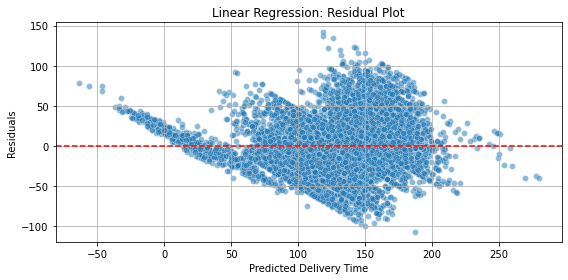

In [8]:
# Residual Plot (Calculation of residuals (errors))
residuals = y_test - y_pred_lr
plt.figure(figsize=(8,4))
sns.scatterplot(x=y_pred_lr, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Delivery Time"); plt.ylabel("Residuals")
plt.title("Linear Regression: Residual Plot")
plt.grid(True); plt.tight_layout(); plt.show()

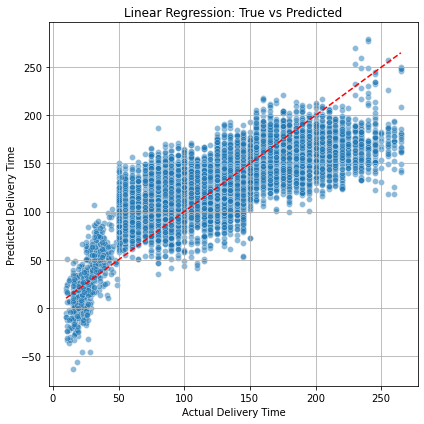

In [9]:
# True vs Predicted Scatter Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.title("Linear Regression: True vs Predicted")
plt.grid(True); plt.tight_layout(); plt.show()

- The model has partially captured linear relationships, but it doesn't seem sufficient for complex relationships.
- Tree-based models like Random Forest and XGBoost can better capture this complexity.

# PART 12.2: Tree-based Models - RF, XGB, LGBM

In [10]:
from sklearn.ensemble import RandomForestRegressor
try:
    from xgboost import XGBRegressor
except:
    XGBRegressor = None
try:
    from lightgbm import LGBMRegressor
except:
    LGBMRegressor = None

results = []

In [11]:
# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300, random_state=42, n_jobs=-1, max_depth=None
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
metrics_rf = evaluate(y_test, y_pred_rf, "Random Forest")
results.append(("Random Forest", metrics_rf, rf_model, y_pred_rf))

     Random Forest | MAE:  17.74 | RMSE:  22.92 | R²:  0.8058


In [12]:
# XGBoost
if XGBRegressor is not None:
    xgb_model = XGBRegressor(
        random_state=42, n_estimators=500, learning_rate=0.08,
        max_depth=6, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        tree_method="hist", verbosity=0
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    metrics_xgb = evaluate(y_test, y_pred_xgb, "XGBoost")
    results.append(("XGBoost", metrics_xgb, xgb_model, y_pred_xgb))
else:
    print("XGBoost not installed — skipping.")

           XGBoost | MAE:  17.94 | RMSE:  22.93 | R²:  0.8055


In [13]:
# LightGBM
if LGBMRegressor is not None:
    lgb_model = LGBMRegressor(
        random_state=42, n_estimators=600, learning_rate=0.06,
        num_leaves=31, subsample=0.9, colsample_bytree=0.9
    )
    lgb_model.fit(X_train, y_train)
    y_pred_lgb = lgb_model.predict(X_test)
    metrics_lgb = evaluate(y_test, y_pred_lgb, "LightGBM")
    results.append(("LightGBM", metrics_lgb, lgb_model, y_pred_lgb))
else:
    print("LightGBM not installed — skipping.")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 34812, number of used features: 45
[LightGBM] [Info] Start training from score 124.514535
          LightGBM | MAE:  17.53 | RMSE:  22.43 | R²:  0.8139


In [14]:
# Diagnostic graphic function
def plot_model_diagnostics(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, 'r--')
    plt.xlabel("Actual Delivery Time")
    plt.ylabel("Predicted Delivery Time")
    plt.title(f"{model_name}: True vs Predicted")
    plt.grid(True); plt.tight_layout(); plt.show()

    residuals = y_true - y_pred
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Delivery Time"); plt.ylabel("Residuals")
    plt.title(f"{model_name}: Residual Plot")
    plt.grid(True); plt.tight_layout(); plt.show()

In [15]:
# Find the best (lowest MAE) model
def pick_best(results_list):
    # results_list: list of tuples (name, metrics_dict, model_obj, y_pred_array)
    best = None
    for name, m, mdl, yhat in results_list:
        if best is None or m["MAE"] < best[1]["MAE"]:
            best = (name, m, mdl, yhat)
    return best


Best model: LightGBM | {'MAE': 17.531449681054806, 'RMSE': 22.43392727300158, 'R2': 0.8139146899500842}


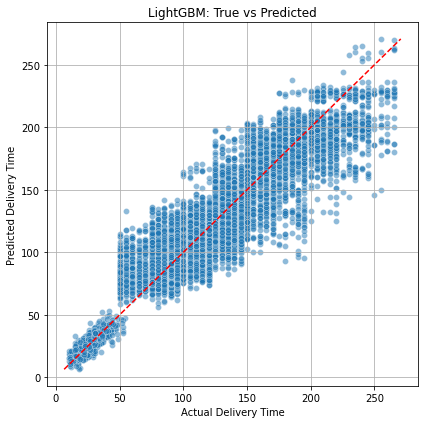

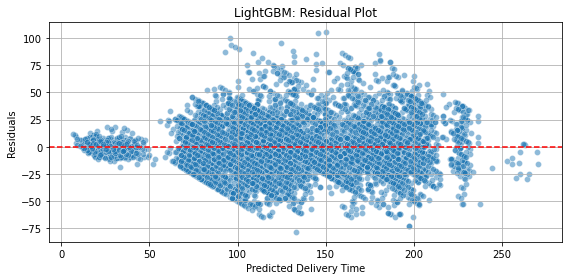

In [16]:
best_name, best_metrics, best_model, best_pred = pick_best(results)
print("\nBest model:", best_name, "|", best_metrics)

# Draw diagnostic charts for the best model
plot_model_diagnostics(y_test, best_pred, model_name=best_name)

- LightGBM gave the best results:
- Random Forest also shows strong performance but may be a bit slower and have higher resource consumption.
- XGBoost is very close to Random Forest but not as good as LGBM.
- Linear Regression is insufficient for explaining complex relationships for this dataset.

# PART 13: Feature Importance (LightGBM)

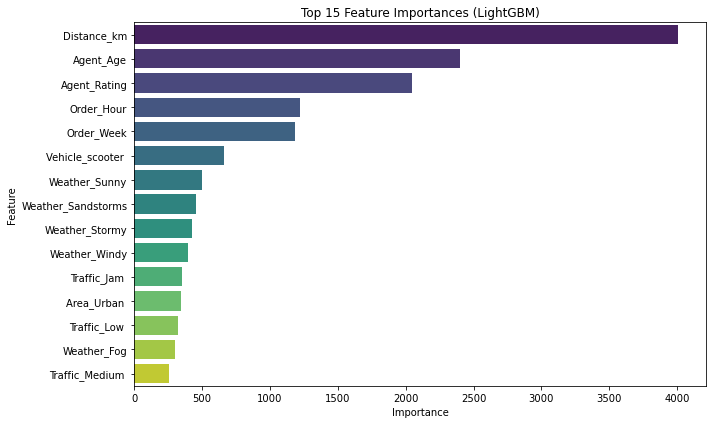

In [17]:
importances = lgb_model.feature_importances_
features = X_train.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Outline the 15 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')
plt.title("Top 15 Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

📊 Most Influential Features:
- Distance_km: The variable with the greatest impact on delivery time. As distance increases, delivery time is expected to increase. Therefore, it is logical for the model to place high importance on this variable.
- Agent_Rating & Agent_Age: Courier quality (score) and age are important factors. Couriers with higher scores and/or younger couriers are generally able to deliver faster.

🚲 Vehicle and Weather Impact:
- Vehicle_scooter & Vehicle_van: Vehicle type is also an important factor. Scooters are generally used for faster delivery, so they have a high importance.
- Weather (Sunny, Stormy, Sandstorms, Windy, Fog): Weather conditions also play an important role.
- Particularly bad weather conditions (stormy, foggy, etc.) can delay delivery, while sunny weather has a positive effect.

🕒 Time Factors:
- Order_Hour & Order_Week: The time and week of the order are linked to external factors such as traffic and congestion.
- This shows that the model can capture time-related patterns.

🚦 Traffic and Area:
- Traffic_Low & Traffic_Medium: Traffic level is a useful variable for prediction. However, the Traffic_Jam variable did not make it into the top 15, possibly because it was observed very little in the data.
- Area_Urban: The urban nature of the area may affect delivery time.
- Factors such as traffic or density may be more pronounced in urban areas.

🎯 Conclusion: This analysis revealed which variables the model "relies" on more. The fact that logical variables like Distance, Rating, and Age appeared first also shows that the model is learning correctly.

# PART 14: Save Artifacts for Step 3 (Risk & Routing)

In [18]:
# ===============================
# 02 -> 03 ARTIFACT RECORDING (ADDITIONAL BLOCK) — TIME-BASED SAFE
# ===============================
from pathlib import Path
import joblib

# Project paths
ROOT = Path("..")            # 02_modelling.ipynb is located under notebooks/
OUT_DIR = ROOT / "data" / "processed"
MODEL_DIR = ROOT / "models"
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Test IDs: keep original row ID and Order_ID
test_ids = test_df[["_row_id", "Order_ID"]].copy()

# 1) X_test output: features + IDs
X_test_out = X_test.copy()
X_test_out = X_test_out.reset_index(drop=True)              # Security: prevent indexing confusion after dummies.
X_test_out = pd.concat([test_ids.reset_index(drop=True), X_test_out], axis=1)

# 2) y_test output: y_true + IDs
y_test_out = pd.DataFrame({
    "_row_id": test_ids["_row_id"].values,
    "Order_ID": test_ids["Order_ID"].values,
    "y_true": y_test.values
})

# 3) y_pred output: prediction + IDs (LightGBM best)
y_pred_out = pd.DataFrame({
    "_row_id": test_ids["_row_id"].values,
    "Order_ID": test_ids["Order_ID"].values,
    "y_pred": y_pred_lgb  # en iyi model LGBM ise
})

#4) Write to files
X_test_out.to_csv(OUT_DIR / "X_test.csv", index=False)
y_test_out.to_csv(OUT_DIR / "y_test.csv", index=False)
y_pred_out.to_csv(OUT_DIR / "y_pred.csv", index=False)

# 5) Save the model
joblib.dump(lgb_model, MODEL_DIR / "lightgbm_delivery.pkl")

#6) (Optional) Features used
(pd.Series(X_train.columns, name="features")
   .to_frame()
   .to_csv(MODEL_DIR / "features_used.csv", index=False))

print("Artifacts saved:")
print(" - Model:", MODEL_DIR / "lightgbm_delivery.pkl")
print(" - X_test:", OUT_DIR / "X_test.csv")
print(" - y_test:", OUT_DIR / "y_test.csv")
print(" - y_pred:", OUT_DIR / "y_pred.csv")
print(" - features_used:", MODEL_DIR / "features_used.csv")

Artifacts saved:
 - Model: ..\models\lightgbm_delivery.pkl
 - X_test: ..\data\processed\X_test.csv
 - y_test: ..\data\processed\y_test.csv
 - y_pred: ..\data\processed\y_pred.csv
 - features_used: ..\models\features_used.csv
